<a href="https://colab.research.google.com/github/yahyakkhalid/Twitter-data-sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Téléchargement de bibliothèques

In [ ]:
! pip install -q -U --upgrade scikit-learn==0.24 sklearn statsmodels hypertools pdpbox matplotlib==3.2.2 spacy==3.1.0 nltk==3.2.4 gensim scipy stopwordsiso pyspellchecker textblob_fr vaderSentiment-fr
! pip install -q -U git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
! pip install -q -U python-Levenshtein # Le module d'extension C contient des fonctions pour accélérer le calcul (word2vec, fasttext...)
! pip install -q -U gdown

# Script de création de corpus
### *https://github.com/yahyakkhalid/Twitter-data-sentiment-analysis/blob/main/creation_corpus.ipynb*

# Téléchargement de corpus (résultat du script)

In [2]:
! gdown --id 1FrMd6HSVlLSk0Dj7fv-qJcZ0s9ZpNtVV

Downloading...
From: https://drive.google.com/uc?id=1FrMd6HSVlLSk0Dj7fv-qJcZ0s9ZpNtVV
To: /content/corpus_tweets.zip
100% 110M/110M [00:01<00:00, 92.4MB/s]


# Importation des bibliothèques

In [3]:
import os
from zipfile import ZipFile

import re
import pandas as pd
import numpy as np

from multiprocessing import cpu_count

import matplotlib.pyplot as plt

from spellchecker import SpellChecker
from spacy.lang.fr import stop_words as fr_stop
import stopwordsiso

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

from sklearn.manifold import TSNE

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
from textblob.sentiments import NaiveBayesAnalyzer

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# Extraction du corpus

In [4]:
with ZipFile('corpus_tweets.zip', 'r') as zf:
    zf.extractall('./')

# Telechargement des bibliothèque de NLTK

- punkt: NLTK tokenizer
- stopwords
- movie_reviews: dataset pour l'analyseur de sentiments naïf bayes
- vader_lexicon: outil d'analyse de sentiments basé sur des règles et un lexique

In [5]:
nltk.download(['punkt', 'stopwords', 'movie_reviews', 'vader_lexicon'], quiet = True)

True

# Création d'un répertoire pour l'exportation de données

In [6]:
export_dir = 'exports/'
if not os.path.isdir(export_dir):
   os.mkdir(export_dir)

# Importation et chargement du corpus

In [7]:
corpusdir = 'corpus_tweets/'
data = []

for filename in os.listdir(corpusdir):
  with open(corpusdir + filename, mode='r') as file:
    data.append(file.read())

tweets_df = pd.DataFrame(data, columns = ['tweet'])

In [8]:
print(f'{tweets_df.shape[0]} tweets')

300000 tweets


# Supprimer les tweets en double

In [9]:
print(f'{len(tweets_df.loc[tweets_df.duplicated()])} duplicated tweets')

4599 duplicated tweets


In [10]:
tweets_df.drop_duplicates(inplace = True)

# Un échantillon des tweets 

In [11]:
pd.set_option('display.max_colwidth', None)

tweets_df.sample(10)

,tweet
112150,"L’image la plus ridicule de 2021, pass sanitaire pour skier, masque obligatoire, et un petit pot de gel hydroalcoolique en plein milieu de la file d’attente aucune logique comme depuis le départ… #ski #COVID19 #hiver https://t.co/ILl0fe2Yg0"
129977,"@Enthoven_R Les urgences incapables de gerer les hospitalisations COVID19. Fermer des lits en pleine pandemie, c'est pas le vrai scandale? qu'est ce que vous allez faire quand vous vous prendrez un virus type Ebola a gerer? \nGouverner c'est prevoir ...@Enthoven_R @ivanrioufol"
77724,@Vadeboncoeur_Al D'accord pour qu'ils nous fassent confiance! \n\nMais qu'ils nous donnent les informations nécessaires pour nous protéger! \n\nC'est décourageant ben raide. 🤦\n\n#covid19 #polqc #covidisairborne
286397,@evelyneboudeau Il a fallu trois doses pour comprendre ???\nCeux qui supportent 3doses feront la 4em et ainsi de suite !\nMoi le covid19 m'a attrapé le 4 novembre 2020 et je ne ferai jamais de vaccin !\nEt si un variant (même s'il découle d'un vaccin) je n'en ai pas peur !\nSi je dois succomber https://t.co/zhHqjurdhZ
240393,#Covid19. De nouvelles mesures en #SeineMaritime. Suivez ici la conférence de presse du préfet qui débute dans quelques instants. https://t.co/1OHqbJzI4a
107106,"Ce qui n'était que de la théorie devient réalité : les thérapies géniques #ARNm détruisent l'immunité naturelle contre les autres #variants et autres #virus.\nDécidément, les #complotistes ont souvent raison. #COVID19 #Vaccin #VaccinationObligatoire \n \nhttps://t.co/zzSUljYhdq"
295309,"#COVID19 cette fois c’est sûr, on n’en sortira jamais. Chaque hiver, même problème. Bref, l’humanité a créé sa propre perte. Que c’est beau d’avoir 30ans en 2021/2022. Je parle des trentenaires, mais les plus jeunes, sont les bienvenus pour s’exprimer aussi!"
123971,"Tu veux te faire vacciner mais tu\nne sais pas où te rendre. Retrouve le\ncentre de vaccination de ta\nlocalité en visitant ce lien\nhttps://t.co/E3fDbXbSnu.\nJe suis jeune, je me vaccine contre\nla COVID-19.\n#CampagneDigitale2021\n#Vaccination #COVID19 #Sante\n#wasexo https://t.co/MPpBn3UYzW"
93995,"L'info du 14 déc 2021 : 'Avec tout ce que je sais, on pourrait faire un livre. Avec tout ce que je ne sais pas, on pourrait faire une bibliothèque' S. Guitry, #Covid19, Variants, #Police, #Violences #urbaines, Présidentielle 2022 #RafikSmati ?, #Loup...- https://t.co/fOWCRSpMJL https://t.co/2opMyMMFtk"
154333,On en se sortira pas de ce Covid par les injections mais par Omicron qui est moins dangereux pour tous et tout cela NATURELLEMENT sans Pfizer entreprise de bandits multirécidivistes avec une liste de condamnation longue comme le bras ! \n\n#Trudeau @JustinTrudeau \n#COVID19 #Pfizer https://t.co/tOw6Gd68AO


In [12]:
tweets = tweets_df.copy()

# Traitement des émojis

## Décodage ses emojis et les traduire en français

### Demande de récuperation des émojis au site :
> https://emojiterra.com/fr/points-de-code

In [13]:
import urllib.request
from bs4 import BeautifulSoup

user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
url = "https://emojiterra.com/fr/points-de-code/"
headers = {'User-Agent': user_agent} 

request=urllib.request.Request(url, None, headers)
response = urllib.request.urlopen(request)
data = response.read()

### Récupération du tableau des émojis

In [14]:
soup = BeautifulSoup(data, 'html.parser')
table = soup.find('table')
emojis_df = pd.read_html(str(table))[0]

In [15]:
emojis_df.sample(10)

,#,Emoji + Unicode CLDR Short Name,Point(s) de code Unicode
3054,3055,🚣🏾‍♀️ Rameuse Dans Une Barque : Peau Mate,U+1F6A3 U+1F3FE U+200D U+2640 U+FE0F
2043,2044,👨🏽 Homme : Peau Légèrement Mate,U+1F468 U+1F3FD
261,262,🤦‍♀️ Femme Avec La Paume Sur Le Visage,U+1F926 U+200D U+2640 U+FE0F
1910,1911,☝🏿 Index Pointant Vers Le Haut : Peau Foncée,U+261D U+1F3FF
2789,2790,🧛🏾‍♀️ Vampire Femme : Peau Mate,U+1F9DB U+1F3FE U+200D U+2640 U+FE0F
406,407,👯‍♂️ Hommes Avec Des Oreilles De Lapin,U+1F46F U+200D U+2642 U+FE0F
3194,3195,🧘🏾 Personne Dans La Posture Du Lotus : Peau Mate,U+1F9D8 U+1F3FE
779,780,🌎 Globe Tourné Sur Les Amériques,U+1F30E
1263,1264,⚒️ Marteau Et Pioche,U+2692 U+FE0F
1894,1895,👆🏾 Main Avec Index Pointant Vers Le Haut : Peau Mate,U+1F446 U+1F3FE


### Séparation des emojis de leurs textes respectifs

In [16]:
emojis_table = emojis_df['Emoji + Unicode CLDR Short Name'].values.tolist()
emojis = {}
for line in emojis_table:
  emoji, text = line.split(' ', 1)
  emojis[emoji] = text

In [17]:
emojis.get('😇')

'Visage Souriant Avec Auréole'

## Définition d'une fonction qui convertit les emojis récupérés en texte

In [18]:
def demojize(text):
  global emojis
  words = text.split()
  for idx, word in enumerate(words):
    word_ = ''
    for char in word:
      if char in emojis.keys():
        char = " " + emojis[char] + " "
      word_ += char
    words[idx] = word_
  return " ".join(words)

### Test de la fonction

In [19]:
demojize('😁vaccin 😁😇 Bon, 😉')

' Visage Souriant Aux Yeux Rieurs vaccin  Visage Souriant Aux Yeux Rieurs  Visage Souriant Avec Auréole  Bon,  Visage Faisant Un Clin D’œil '

## Conversion des emojis en texte pour l'analyse des sentiments

In [20]:
tweets['tweet_emojis'] = tweets['tweet'].apply(lambda tweet: demojize(tweet))

# Test de subjectivité

## *Simple french analyzer*

In [21]:
tb_fr = Blobber(pos_tagger = PatternTagger(), analyzer = PatternAnalyzer())
tweets['subjectivité'] = tweets['tweet_emojis'].apply(lambda tweet: tb_fr(tweet).sentiment[0])

In [22]:
tweets.sample(10)

,tweet,tweet_emojis,subjectivité
187725,#omicron #COVID19 #covidvariant #Macron #Frexit \n\nSi certains attendent encore des journalistes qu ils fassent leur travail....\nVous pouvez attendre longtemps...\nIls font partie de la même secte que leurs maitres.... https://t.co/IM1Cnz9siB,#omicron #COVID19 #covidvariant #Macron #Frexit Si certains attendent encore des journalistes qu ils fassent leur travail.... Vous pouvez attendre longtemps... Ils font partie de la même secte que leurs maitres.... https://t.co/IM1Cnz9siB,0.290000
199698,"@Morgane_La_Fee @NatSchirvel @nicomedbxl Explications concernant le concept très délicat de l'effet moisson, en général et dans le contexte de la pandémie Covid19 :\nhttps://t.co/wvfNVj0pVQ","@Morgane_La_Fee @NatSchirvel @nicomedbxl Explications concernant le concept très délicat de l'effet moisson, en général et dans le contexte de la pandémie Covid19 : https://t.co/wvfNVj0pVQ",0.250000
195271,"Dans les hôpitaux aubois, il y a 46 patients (-) dont 36 en unité classique (+2), 1 en rééducation ou soins de longue durée (-1) et 9 en soins critiques (-1). Au total, 467 décès (+2). 15 nouvelles hospitalisations (+12).\n#Troyes #Coronavirus #covid19 #aube #vaccin #delta 5/7 https://t.co/51NH7KYKBl","Dans les hôpitaux aubois, il y a 46 patients (-) dont 36 en unité classique (+2), 1 en rééducation ou soins de longue durée (-1) et 9 en soins critiques (-1). Au total, 467 décès (+2). 15 nouvelles hospitalisations (+12). #Troyes #Coronavirus #covid19 #aube #vaccin #delta 5/7 https://t.co/51NH7KYKBl",0.083333
5080,"#Covid19: quelle stratégie #vaccinale pour les enfants ? Explications du Pr Alain Fischer, pédiatre et président du Conseil d'orientation de la stratégie vaccinale sur @franceinfo https://t.co/emwWZERFiJ","#Covid19: quelle stratégie #vaccinale pour les enfants ? Explications du Pr Alain Fischer, pédiatre et président du Conseil d'orientation de la stratégie vaccinale sur @franceinfo https://t.co/emwWZERFiJ",0.000000
35900,"""La situation actuelle en #Allemagne est dramatique, on ne peut pas le dire autrement"", a déclaré Angela #Merkel à propos de la situation sanitaire dans le pays.\n\nL'#Europe est de nouveau l'épicentre de la pandémie de #Covid19. Le point sur la situation https://t.co/N23mmGQgZD","""La situation actuelle en #Allemagne est dramatique, on ne peut pas le dire autrement"", a déclaré Angela #Merkel à propos de la situation sanitaire dans le pays. L'#Europe est de nouveau l'épicentre de la pandémie de #Covid19. Le point sur la situation https://t.co/N23mmGQgZD",0.080000
54391,"Je suis d'accord avec Klaus Schwab.\nLa crise du Covid19 représente en effet une rare fenêtre d'opportunité.\nNon pour la mise en esclavage du bétail humain, mais pour un Great Reset humaniste, avec mise à mort des structures permettant le totalitarisme.","Je suis d'accord avec Klaus Schwab. La crise du Covid19 représente en effet une rare fenêtre d'opportunité. Non pour la mise en esclavage du bétail humain, mais pour un Great Reset humaniste, avec mise à mort des structures permettant le totalitarisme.",0.153333
274268,Tests #Covid19 : la politique de dépistage massif a-t-elle encore un sens avec Omicron ? https://t.co/rLgyoy7HjD,Tests #Covid19 : la politique de dépistage massif a-t-elle encore un sens avec Omicron ? https://t.co/rLgyoy7HjD,0.000000
290830,"La Covid19 nous a touché psychologiquement, et physiquement, a fragilisé notre économie durant la pandémie !!!\nNe permettons plus cela de se reproduire en nous faisant vacciner le plus tôt possible !!!\n#WaHagoyDaCovid19\n#LesVaccinsÇaMarche\n@Unicefniger https://t.co/gXVR3yJ8uT","La Covid19 nous a touché psychologiquement, et physiquement, a fragilisé notre économie durant la pandémie !!! Ne permettons plus cela de se reproduire en nous faisant vacciner le plus tôt possible !!! #WaHagoyDaCovid19 #LesVaccinsÇaMarche @Unicefniger https://t.co/gXVR3yJ8uT",0.100000
206756,"Plus de deux mois après la réception d’une donation de 500,000 doses de #Moderna, #H

> Un score élevé de *subjectivité* indique qu'il s'agit principalement d'une opinion publique et non d'une information factuelle.

## Filtrer les tweets subjectifs
- Seuil (*Threshold*) : 35%

In [23]:
tweets = tweets[tweets['subjectivité'] >= 0.35]

In [24]:
print(f'{tweets.shape[0]} tweets subjectives')

18747 tweets subjectives


In [ ]:
tweets.drop('subjectivité', axis = 1, inplace = True)
tweets.reset_index(inplace = True, drop = True)

# Analyse des sentiments

> On va tester deux analyseur des sentiments du langage française.

## *Simple analyzer*

### Mesure de la polarité

In [26]:
tweets['polarité_simple'] = tweets['tweet_emojis'].apply(lambda text: tb_fr(text).sentiment[1])

### Déduction du sentiment à partir de coefficient de polarité

In [27]:
tweets['sentiment_simple'] = tweets['polarité_simple'].apply(lambda x: 'Negative' if x < 0 else ('Neutre' if x == 0 else 'Positive'))

In [28]:
tweets[['tweet', 'sentiment_simple']].sample(10)

,tweet,sentiment_simple
6828,#VaccinationCovid info venant de suisse les amis! #COVID19 https://t.co/Axy78f5eOW,Positive
13559,"@y_drean @Mike_Bresson @BHaristoy J'ai un esprit critique et pas une lecture biaisée de ce graphique des bourses. Le covid19 a chamboulé le marché et l'injection de plusieurs centaines de milliards dans.le marché à une conséquence, des marchés super chèr et surévalué.",Positive
17720,Se faire vacciner pour se protéger et protéger celles et ceux que l’on aime. #solidarite #COVID19 https://t.co/ILI38UuhIE,Positive
14924,Je me posais une question Messi l’un des meilleurs joueur du monde as t’il déjà marqué un but sous la CHASUBLE du PSG ? #COVID19 #PSGMCI @Betclic #fanpsg,Positive
17173,@ladepechedumidi A cause du #COVID19 ? Vous auriez du rajouter aussi à cause des #NonVaccinés ? #ladepechedumidi quelle neutralité ! Ca c est du grand journalisme ! https://t.co/Gm6QEcaDyf,Positive
9575,"L'incidence est désormais en très légère baisse sur une semaine (-2,24%). Seuil d'alerte de 0 à 60 ans et de 70 à 90ans, l'impact est très fort chez les 10/30ans mais a tendance à diminuer.\n #Troyes #Coronavirus #covid19 #aube #vaccin #delta 3/6 https://t.co/Mq5Np3ql5E",Positive
9082,"#PortoRico , bon élève pour la vaccination, connaît une explosion des cas de #Covid19 … comme c’est surprenant !!! Et que dire de La France avec ses 300 000 cas positifs quotidiens … Est-ce un coup des “non-vaccinés” ou des anticorps neutralisants ? https://t.co/9PQ0hNpmsb",Positive
5738,"@rastarocket16 #Macron ...Un ""Thaumaturge"" qui s'ignore ‼️😁 ...Voir #Macron et attraper le #COVID19 ⁉️🤔 ... https://t.co/YghDcV6crn",Positive
16023,https://t.co/9iq5ve8Yab Comment asservir le peuble ? Très bon article dans le Devoir. #soumission #COVID19 #COVID #vaccination #PasseSanitaire #Droits2022,Positive
1785,3 décès post-vaccination Pfizer anti-covid dans le Sud. Les familles veulent comprendre !\n#Coronavirus #vaccins#effets secondaires graves #covid19 https://t.co/amov1r361B,Positive


## *VADER* (Valence Aware Dictionary et sEntiment Reasoner)

> Le *compound score* est la somme des scores positifs, négatifs et neutres, le score est ensuite normalisé entre -1 (négatif le plus extrême) et +1 (positif le plus extrême)

In [29]:
SIA = SentimentIntensityAnalyzer()
tweets['polarité_vader'] = tweets['tweet_emojis'].apply(lambda text: SIA.polarity_scores(text)['compound']) # compound = agrégé

In [30]:
tweets['sentiment_vader'] = tweets['polarité_vader'].apply(lambda x: 'Negative' if x < 0 else ('Neutre' if x == 0 else 'Positive'))

> Plus le *compound score* est proche de +1, plus la positivité du texte est élevée

In [31]:
tweets[['tweet', 'sentiment_simple', 'sentiment_vader']].sample(10)

,tweet,sentiment_simple,sentiment_vader
9378,"@LPLdirect ""porter le #masque entre chaque bouchée ou encore mettre + de rallonges aux tables pour ""sauver #Noel""\n😂🤣\n#COVID19 #COVID19France #Vaccin",Neutre,Positive
11996,#Coronavirus en Pays - de - la - #Loire : La region toujours en avance sur [ https://t.co/5b0faow1BP ] Il y a 5heures Le cap des trois millions de personnes ayant recu au moins une premiere dose de vaccin contre le #Covid19 vient d'etre franchi en Pays - https://t.co/knufOJEDTz,Positive,Positive
4206,@jsanchez_rn Beau pied-de-nez à ce gouvernement délirant avec leur #Covid19 utilisé pour dompter le peuple et se prémunir de toute attaque en justice.\nBravo pour ce choix et cette organisation 👏,Positive,Positive
15581,"#COVID19 poursuite de la baisse du taux de reproduction ""R"" à 1,32 contre 1,36 hier, et le nombre d'admissions en soins critiques augmente par suite moins vite....nous tenons le bon bout 😋😋😋",Positive,Positive
2729,"Bon, pour le Covid19 faites comme Sarkozy immunité immunité; comprende? immunité immunité",Positive,Positive
4973,"Quelles sont les prévisions de @OITinfo pour l'avenir du #TravailÀDistance ? L'expert de l'OIT Jon Messenger affirme que ""la grande expérience du #télétravail en temps de pandémie est finie"". Au-delà du #COVID19, le #télétravail partiel serait la meilleure approche, ajoute-t-il. https://t.co/mCB14ZIDsT",Positive,Positive
16519,📣Organismes gestionnaires d'#ESSMS : comment intégrer les impacts de la crise #COVID19 dans le dialogue de gestion ?\n🎙 Nos partenaires experts seront là pour vous éclairer lors des rdv budgétaires @ORCOMFrance \n➡ Programme complet &amp; inscription : https://t.co/sNded6tjHd https://t.co/Z3rcifpLqo,Positive,Neutre
5175,Le @cardinalrlburke est de retour! \n😇 #ThanksBeToGod #COVID19 https://t.co/uCTuVoC5sf,Positive,Positive
5836,"Pendant que des millions de nos concitoyens 🇫🇷 font des efforts pour espérer avoir la vie d'avant, @f_philippot @LFI_Forever @GiletsJaunesFr_ @FrancisLalanne4 emmènent la minorité D 🇫🇷 à l'abattoir Le PR @EmmanuelMacron a pris de bonnes décisions #Covid19 #VariantDelta #Variants https://t.co/VuSrPdZmZu",Positive,Positive
11008,"Omicron : le #Royaumeuni resserre la vis en imposant un test Covid [ https://t.co/BcArdyqhrD ] Il y a 18heures a durci le ton et decide d'imposer des demain mardi 7 decembre, un test #Covid19 negatif a presenter avant d'entrer sur le territoire du Royaum https://t.co/RlNbFM24f5",Positive,Negative


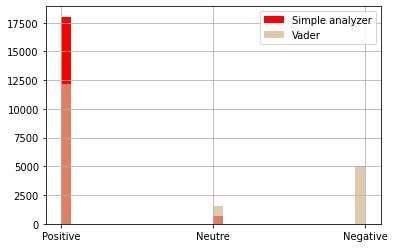

In [32]:
tweets['sentiment_simple'].hist( bins = 30, color = 'red', alpha = 1)
tweets['sentiment_vader'].hist( bins = 30, color = 'tan',  alpha = 0.7)
plt.legend(["Simple analyzer", "Vader"])

> *Simple Sentiment Analyzer* ne donne pas de résultats exacts, et ne fait pas la distinction entre les opinions et les informations factuelles, par contre *Vader* donne des résultats plus précis.

In [33]:
tweets.drop(['tweet_emojis', 'polarité_simple', 'sentiment_simple', 'polarité_vader'], axis = 1, inplace = True)
tweets.rename(columns = {'sentiment_vader': 'sentiment'}, inplace = True)

In [34]:
tweets.sample(10)

,tweet,sentiment
12222,Allez #bonnenuit ... bon #weekend ... #joyeuxnoel et #bonneannee !\n\nMoi je vais hiberner ! #COVID19 #Variant https://t.co/ucmNK1CcOW,Positive
4152,Demain c'est la #rentrée. Demain c'est la deuxième rentrée avec la #COVID19. Aurons nous un jour une rentrée sans masque et sans virus ? Espérons. En attendant faut remettre cet enfoiré de ⏰ !\nBonne reprise ! #teamVieScolaire #CPE #lycée https://t.co/ziFijRhRoi,Negative
9776,"#COVID19&gt; ""Un très grand scientifique en frontale avec l’#hydroxychloroquine à 2€ la boîte face aux laboratoires ça ne peut pas fonctionner !..."", sauf si le peuple l'exige unitairement... #TouchePasARaoult https://t.co/bkUAmiQF56",Negative
6314,"Menée sur des participants ayant reçu 2 doses de vaccin à ARNm #COVID19, cette étude montre que la protection immunitaire contre un ensemble de variants émergents est meilleure pour les participants ayant été infectés #SARS_Cov_2 avant leur vaccination 1/2\nhttps://t.co/iNoT7AtYZ3",Positive
10629,8/10) #VACCINATION #COVID19 #CATALOGNE #BARCELONE publiée auj. 07/12 10h45\nVaccinés Catalogne 1ere dose: 6.090.812 (77.01%). Tot. complet: 75.3%\nVaccinés Barcelone 1ere dose: 1.364.308 (78.28%). Tot. complet: 76.5%\nL'AUGMENTATION DE LA VACCINATION RALENTIT.\nSource @salutcat https://t.co/RCSihUHyJq,Positive
7256,"Durant ces #100premiersjours, @exteriorscat a:\n\n ➡️Créé le Conseil de la Catalogne de l’ext.\n ➡️Lancé la vaccination #covid19 @salutcat\n ➡️Créé la direction généralement de @Catextterior\n\nNotre priorité : améliorer l’offre et la qualité des services aux catalan•es de l’ext. https://t.co/O0TabnlCSy",Positive
14272,@PauloEastvan Excellent! @VinChris246 #COVID19,Positive
9457,"(UNE BOMBE !!!) JEAN BERNARD FOURTILLAN - Interview Hold-up complète - Malaria, Sida, Covid19 créé en labo et breveté depuis longtemps ! https://t.co/HiDomvAUmF #LBRY via @OdyseeTeam",Negative
7824,cette tribune @le_Parisien est un pur scandale ! 🤬🤬🤬🤬🤬🤬🤬🤬 #PassVaccinal #PlusCitoyen #VaccinationObligatoire #Vaccin #COVID19 https://t.co/U6vV8sFCUM,Negative
310,@E_Duhaime 🤣🤣🤣🤣 Le gros Kenny tente de faire oublier sa gestion CATASTROPHIQUE de la #covid19 !,Negative


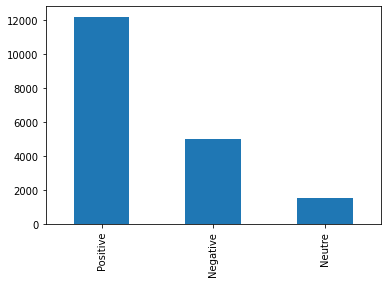

In [35]:
tweets['sentiment'].value_counts().plot.bar()

> En moyenne, l'opinion des francophones sur la situation covid est positive.

## Exportation des tweets avec les sentiments que nous avons obtenus

In [ ]:
! pip install -q -U openpyxl
tweets.to_excel(export_dir + 'tweets_sentiment_data.xlsx', index = False)

# Prétraitement

## Chargement des *Stop-words*

#### Chargement des *Stop-words* français

In [37]:
stopwords = nltk.corpus.stopwords.words('french')
len(stopwords)

157

In [38]:
stopwords = fr_stop.STOP_WORDS
len(stopwords)

507

#### Étant donné que les *Stop-words* de NLTK et Spacy ne sont pas nombreux, nous allons les importer d'une source différente

In [39]:
stopwords = stopwordsiso.stopwords("fr")
len(stopwords)

691

#### Nous pouvons ajouter d'autres *Stop-words*

In [40]:
stopwords.update({'janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre'})
stopwords.update({'lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'})
stopwords.update({'aaaaah', 'aaaah'})

## Suppression des noms personnels

In [41]:
names = []
table = pd.read_table('https://www.usna.edu/Users/cs/roche/courses/s15si335/proj1/files.php%3Ff=names.txt&downloadcode=yes', header = None)
names.extend([name.lower() for _ in table.values.tolist() for name in _])
names = set(names)

## Correcteur d'orthographe

In [42]:
spell = SpellChecker(language = 'fr')
spell.word_frequency.load_words(['covid']) # autoriser d'autres mots non français

## French Lemmatizer

In [43]:
lemmatizer = FrenchLefffLemmatizer()

## French Stemmer

In [44]:
stemmer = SnowballStemmer('french')

## Nettoyage

- Suppression des identifiants Twitter (@user)
- Suppression des URLs du texte
- Suppression des hashtags
- Suppression des ponctuations, des chiffres et des caractères spéciaux
- Suppression des émojis
- Suppression des mots de longueur <= 3
- Suppression des *Stop-words*
- Supprimer des noms de personnels
- Filtrer les mots français
- Correction d'orthographe
- Lemmatisation
- Stemming

In [45]:
def nettoyage(text):
  global stopwords
  global names
  global spell
  global lemmatizer
  global stemmer

  text = re.sub(r'@[\w]*', '', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'#[\w]*', '', text)
  text = re.sub(r'[^A-Za-z#çéâêîôûàèìòùëïü\-]', ' ', text)
  text = [word for word in word_tokenize(text.lower()) if word not in stopwords and len(word) > 3]
  text = [word for word in text if word not in names]
  text = [word for word in text if word not in spell.unknown(text)]
  text = [spell.correction(word) for word in text]
  text = [lemmatizer.lemmatize(word, 'n') for word in text]
  text = [stemmer.stem(word) for word in text]

  return " ".join(text)

In [46]:
tweets['processed_tweet'] = tweets['tweet'].apply(lambda tweet: nettoyage(tweet))

In [47]:
tweets.sample(10)

,tweet,sentiment,processed_tweet
12669,Attention c'est #jeanpierre qui parle !!! Je l'adore toujours autant.\n#NonAuPassDeLaHonte \n#JeNeMeFeraiJAMAISVacciner \n#COVID19 https://t.co/utwakYWRAO,Positive,attent ador
6645,"Putaaaiiin!!!\nUn enculé créé un compte ""Toute l'info positive autour du #Covid19. Pour 1 #vaccination massive, rapide""\n😄😆😂🤣\nLes fils de pute abondent! https://t.co/2tw8aEoUJ1",Positive,encul cré compt info posit autour massiv rapid fil put abondent
15424,INCROYABLE! Rebondissements !\nNovack Djokovic sommet de montrer ça preuve vaccinal sous-peine d'expulsion du territoire Australien.\n\nBienvenue dans le nouveau monde.\n\n#PasseVaccinal\n#COVID19\n#Djokovic https://t.co/al6G1QRAib,Positive,incroi rebond sommet montr preuv expuls territoir australien bienvenu mond
76,"à lire, très clair\n#COVID19 #COVID19France https://t.co/31aVshlByg",Positive,lir
6175,"🔥 🔥 🔥 L'entretien décapant du Docteur Bernard Kron: « A mon sens, est complotiste celui qui refuse que l’on réponde aux bonnes questions » https://t.co/0o2szxH8le #hôpital #santé #Covid19 https://t.co/UaOOdINRUH",Negative,entretien décap docteur sen refus répond bon question
6748,#coronavirus \n#COVID19 \n\nOn n'est jamais déçu du boulot de @AlexSamTG 😱 https://t.co/EaF0c4ui2t,Negative,jam déçu boulot
6250,Malgré la qualité de l’air dégradée. \nMalgré les températures fraîches \nEt parce que la Covid19 repart de plus belle il va falloir travailler fenêtres ouvertes pour assurer la ventilation des classes de 36 élèves. Bonne reprise tous. \n#CHSCT de l'@Academie_Paris\n@RAIledeFrance https://t.co/HLAqNsHoyg,Positive,qualit dégrad températur fraîch covid repart falloir travaill fenêtr ouvert assur ventil class élev bon repris
9674,"@CANNETEX Un #Bogdanoff mort DU #COVID19 : quoi de plus normal, pour un spécialiste de science-fiction ?😅\n#coronacircus \n#PassNazitaire \n#DictatureEnMarche",Positive,mort normal spécial
8308,"Un très beau Tour de la Guadeloupe 2021, malgré le contexte Covid19. Félicitations à la Team USCG qui n'a pas démérité et que la Ville de Goyave continuera d'accompagner. Bravo à tous les participants, au Comité Régional de Cyclisme de la Guadeloupe et à la population. #Fiers https://t.co/5yXwf5W9ZL",Positive,tour context covid félicit team vill goyav continu accompagn particip comit régional cyclism popul
14413,@HAS_sante favorable à l’élargissement de la vaccination sans obligation à l’ensemble des enfants de 5 à 11 ans https://t.co/rRGz38aExE #COVID19,Positive,favor élarg vaccin oblig ensembl enfant


# Modèles de représentation

## Diviser les données

In [48]:
X = tweets['processed_tweet']
y = tweets['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Tokénisation

In [49]:
word_tokens = X.apply(lambda tweet: word_tokenize(tweet))
train_tokens = X_train.apply(lambda tweet: word_tokenize(tweet))
test_tokens = X_test.apply(lambda tweet: word_tokenize(tweet))

## Modèles de représentation

### BoW - *Bag-of-Words*

In [50]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### Word2Vec

In [51]:
w2vec_model = Word2Vec(vector_size = 300, window = 20, workers = cpu_count())
w2vec_model.build_vocab(word_tokens)
w2vec_model.train(word_tokens, total_examples = len(word_tokens), epochs = 15)

(1763981, 2112375)

### Fast Text

In [52]:
fastText_model = FastText(vector_size = 300, window = 20, workers = cpu_count())
fastText_model.build_vocab(word_tokens)
fastText_model.train(word_tokens, total_examples = len(word_tokens), epochs=15)

(1764048, 2112375)

### Representation

In [53]:
def get_embedding(model, words):
  valid_words = [word for word in words if word in model.wv.index_to_key]
  if valid_words:
      embedding = np.zeros((len(valid_words), 300), dtype=np.float32)
      for idx, word in enumerate(valid_words):
          embedding[idx] = model.wv[word]

      return np.mean(embedding, axis=0)
  else:
      return np.zeros(300)

def vectoriser_avg(model, X):
  X_embeddings = np.array([get_embedding(model, words) for words in X])
  return X_embeddings


> Pour chaque document (tweet), on calcule la somme des vecteurs associés aux mots qui le composent, on met des zéros si le mot n'est pas dans le vocabulaire

## Vectorisation des données d'entrainement et du test

In [54]:
X_train_w2v = vectoriser_avg(w2vec_model, train_tokens)
X_test_w2v = vectoriser_avg(w2vec_model, test_tokens)

In [55]:
X_train_ftxt = vectoriser_avg(fastText_model, train_tokens)
X_test_ftxt = vectoriser_avg(fastText_model, test_tokens)

### Visualisation

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

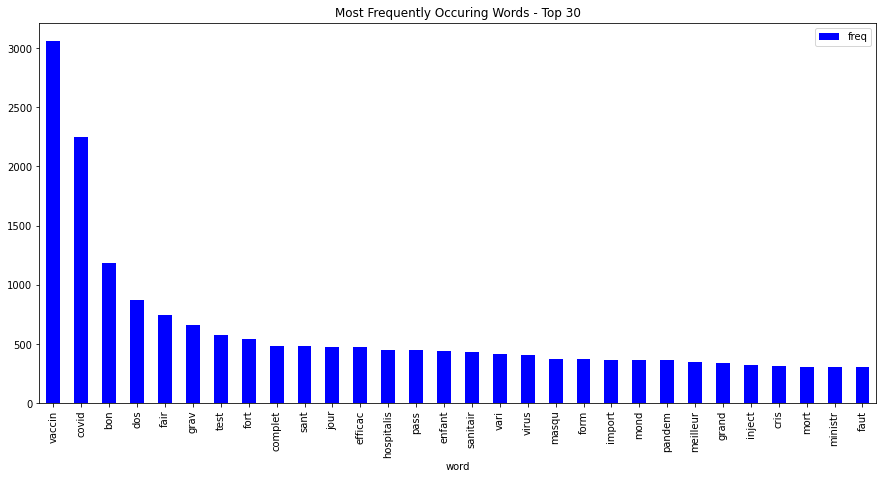

In [56]:
sum_words = X_train_bow.sum(axis=0).tolist()
sum_words.extend(X_test_bow.sum(axis=0).tolist())
sum_words = np.array(sum_words)

words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#### *Bag-of-Words*

In [57]:
pd1 = pd.DataFrame(X_train_bow.toarray())
pd2 = pd.DataFrame(X_test_bow.toarray())
bow_df = pd.concat([pd1, pd2])
bow_df.columns = vectorizer.get_feature_names()

#### Exportation (*Bag-of-Words*)

In [58]:
bow_df.to_csv(export_dir + 'bow.csv', index = False)

In [59]:
bow_df.sample(10)

,abaiss,abaissent,abandon,abandonnon,abat,abattag,abbatu,abbé,abeil,aberr,abject,abneg,aboient,abol,abon,abond,abondent,abord,about,abracadabr,abreuv,abri,absenc,absent,absenté,absolu,absten,abstinent,absurd,abus,abîm,academ,acce,acced,accel,accent,accentu,accept,acceptent,accepton,...,état,éteign,éteindr,étendr,étendu,étern,éternel,éternu,éthiqu,étiquet,étoff,étoil,éton,étouff,étrang,étre,étreint,étren,étron,étud,étudi,étudient,évacu,évalu,évaluent,éveil,éven,éventuel,évid,évident,évinc,évit,évitent,évolu,évoluent,évoqu,évoquent,évêqu,être,île
3492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2648,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5318,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11529,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Déclaration des fonctions de visualisation pour les vecteurs de mots

In [60]:
def TSNE_plot_vocab(model):
  labels = []
  tokens = []

  for word in model.wv.index_to_key:
      tokens.append(model.wv[word])
      labels.append(word)
  
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23, n_jobs = cpu_count())
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
      
  plt.figure(figsize=(16, 16)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
  plt.show()

def TSNE_mots_similaires(model, word):
  arr = np.empty((0,300), dtype='f')
  word_labels = [word]
  nb_sim_words = 10
  close_words = model.wv.similar_by_word(word)[:nb_sim_words]

  arr = np.append(arr, np.array([model.wv[word]]), axis=0)
  for wrd_score in close_words:
    wrd_vector = model.wv[wrd_score[0]]
    word_labels.append(wrd_score[0])
    arr = np.append(arr, np.array([wrd_vector]), axis=0)

  tsne = TSNE(n_components=2, random_state=0)
  np.set_printoptions(suppress=True)
  Y = tsne.fit_transform(arr)

  x_coords = Y[:, 0]
  y_coords = Y[:, 1]

  color = ['red']
  for i in range(nb_sim_words):
    color.append('blue')

  plt.scatter(x_coords, y_coords, c = color)

  for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(1, 5), textcoords='offset points')
  plt.xlim(min(x_coords)-100, max(x_coords)+100)
  plt.ylim(min(y_coords)-100, max(y_coords)+100)
  plt.show()

#### *Word2vec*

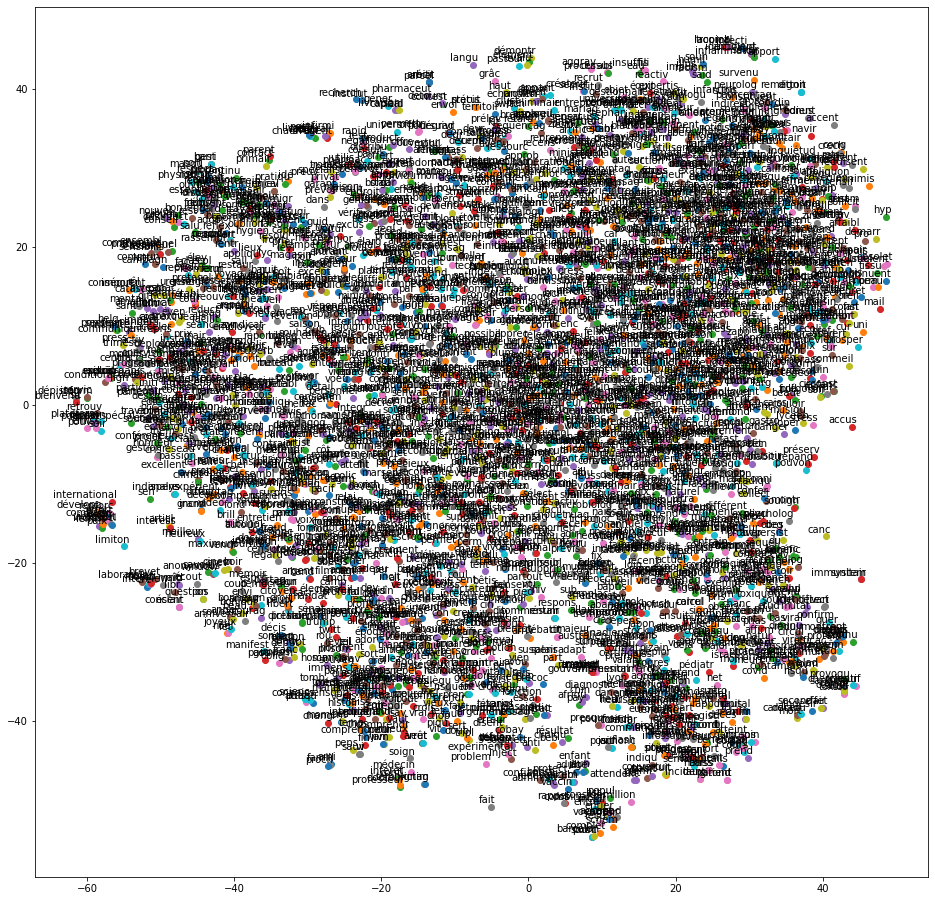

In [61]:
TSNE_plot_vocab(w2vec_model)

In [62]:
w2vec_model.wv.most_similar('vaccin')

[('inject', 0.7785821557044983),
 ('éligibl', 0.7774640917778015),
 ('dos', 0.772231936454773),
 ('beb', 0.7197465300559998),
 ('phas', 0.7094874382019043),
 ('résident', 0.700098991394043),
 ('recommand', 0.6982292532920837),
 ('adult', 0.6842949390411377),
 ('veulent', 0.6808772087097168),
 ('administr', 0.6755409836769104)]

> Les mots les plus corrélés avec *vaccin* et leurs seuils de corrélation

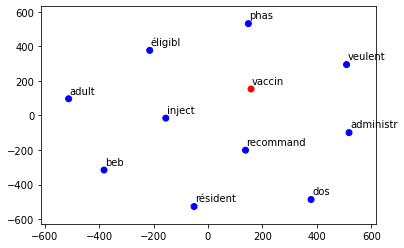

In [63]:
TSNE_mots_similaires(w2vec_model, "vaccin")

#### *Fast Text*

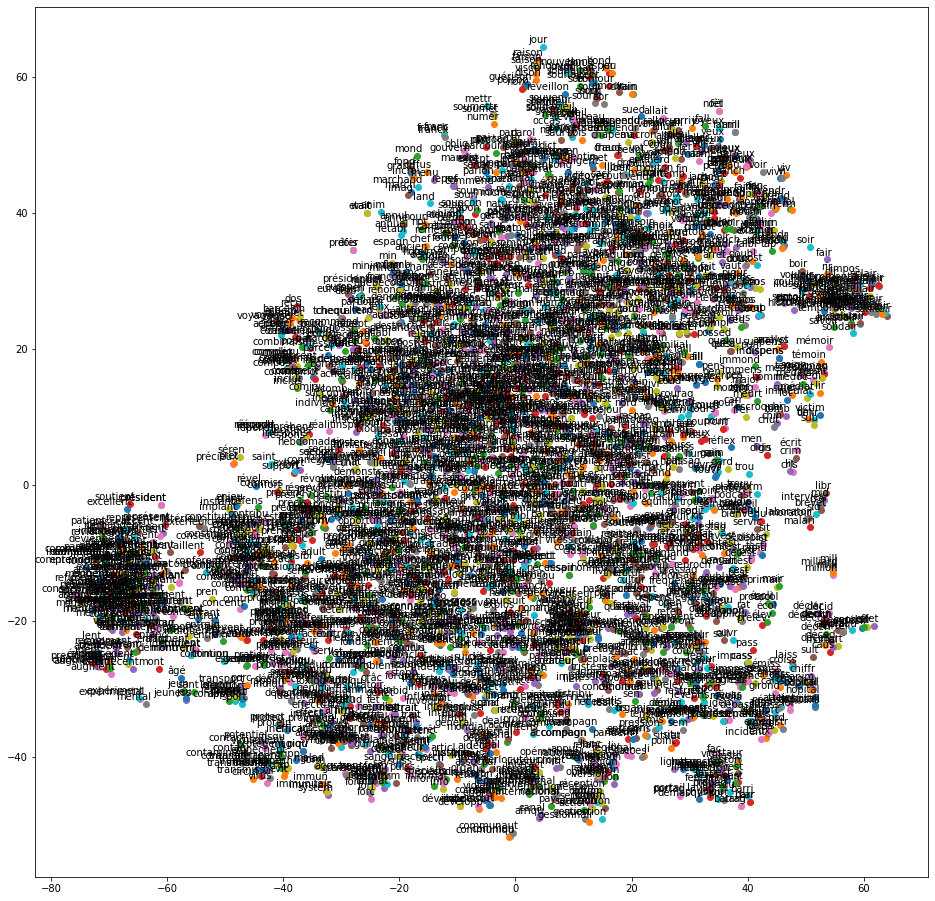

In [65]:
TSNE_plot_vocab(fastText_model)

In [66]:
fastText_model.wv.most_similar('vaccin')

[('dosag', 0.8277341723442078),
 ('inject', 0.823617160320282),
 ('dos', 0.8110486268997192),
 ('rappelon', 0.7887298464775085),
 ('éligibl', 0.785763680934906),
 ('vach', 0.7786218523979187),
 ('frapp', 0.7561701536178589),
 ('piqu', 0.7483900189399719),
 ('affaibl', 0.73709636926651),
 ('rappel', 0.7370466589927673)]

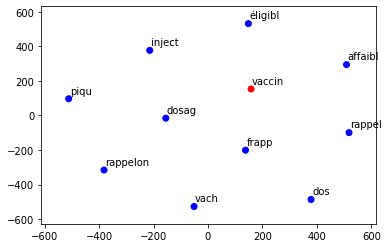

In [67]:
TSNE_mots_similaires(fastText_model, "vaccin")

# Réduction de la dimensionnalité

## *Latent Semantic Analysis/Index*

> Nous utiliserons LSA pour réduire la dimensionnalité des données avant de les intégrer dans un modèle de l'apprentissage automatique.

### *Bag of words*

In [68]:
print(f'dimension initiale {X_train_bow.shape[1]}')

dimension initiale 7628


#### Nous appliquons *LSA*

In [69]:
lsa = TruncatedSVD(n_components=1500, n_iter=100, random_state=42)
lsa.fit(X_train_bow)

TruncatedSVD(n_components=1500, n_iter=100, random_state=42)

#### Informations

In [70]:
lsa.explained_variance_ratio_.sum()

0.8767757778929868

> 87% de l'inertie est conservée après la réduction

#### Transformation

In [71]:
X_train_bow_lsa = lsa.transform(X_train_bow)
X_test_bow_lsa = lsa.transform(X_test_bow)

### *Word2vec*

In [72]:
print(f'dimension initiale {X_train_w2v.shape[1]}')

dimension initiale 300


In [73]:
lsa = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
lsa.fit(X_train_w2v)

TruncatedSVD(n_components=50, n_iter=100, random_state=42)

In [74]:
lsa.explained_variance_ratio_.sum()

0.9989045096739446

> 99% de l'inertie est conservée après la réduction

In [75]:
X_train_w2v_lsa = lsa.transform(X_train_w2v)
X_test_w2v_lsa = lsa.transform(X_test_w2v)

### *Fast Text*

In [76]:
print(f'dimension initiale {X_train_ftxt.shape[1]}')

dimension initiale 300


In [77]:
lsa = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
lsa.fit(X_train_ftxt)

TruncatedSVD(n_components=50, n_iter=100, random_state=42)

In [78]:
lsa.explained_variance_ratio_.sum()

0.9998788844315301

> 99% de l'inertie est conservée après la réduction

In [79]:
X_train_ftxt_lsa = lsa.transform(X_train_ftxt)
X_test_ftxt_lsa = lsa.transform(X_test_ftxt)

# Entrainement du modèle

## Métriques

In [80]:
metrics_bow = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

metrics_w2v = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

metrics_ftxt = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

## *Linear Support Vector Machine*
> *Linear SVM* est plus compatible avec les données textuelles


#### Paramètres

- **loss**: La fonction de perte à utiliser. La valeur par défaut est "hinge", ce qui donne un SVM linéaire, la perte « log » donne une régression logistique, un classificateur probabiliste.
- **alpha**: Constante qui multiplie le terme de régularisation. Plus la valeur est élevée, plus la régularisation est forte.
- **penalty**: Spécifie la norme utilisée dans la pénalisation.

In [81]:
param_svm = {
  "loss" : ["hinge", "log"],
  "alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
  "penalty" : ["l1", "l2"]
}

### *Bag-of-Words*

In [82]:
svm_grid_bow = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [83]:
model_svm_bow = svm_grid_bow.best_estimator_

In [84]:
y_pred = model_svm_bow.predict(X_test_bow_lsa)

In [85]:
metrics_bow.loc[len(metrics_bow)] = [
  'SVM',
  svm_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2vec*

In [86]:
svm_grid_w2v = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [87]:
model_svm_w2v = svm_grid_w2v.best_estimator_

In [88]:
y_pred = model_svm_w2v.predict(X_test_w2v_lsa)

In [89]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'SVM',
  svm_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [90]:
svm_grid_ftxt = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [91]:
model_svm_ftxt = svm_grid_ftxt.best_estimator_

In [92]:
y_pred = model_svm_ftxt.predict(X_test_ftxt_lsa)

In [93]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'SVM',
  svm_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Logistic Regression*

#### Paramètres

- **C**: Inverse de la force de régularisation ; doit être un flottant positif, les valeurs plus petites spécifient une régularisation plus forte.
- **solver**: L'algorithme à utiliser dans le problème d'optimisation.
- **penalty**: L2 "Ridge regression" ajoute la "magnitude au carré" du coefficient comme terme de pénalité à la fonction de perte.
- **max_iter**: Nombre maximal d'itérations nécessaires pour que les solveurs convergent.

In [94]:
param_lr = {
  "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
  "solver": ['newton-cg', 'liblinear'],
  "penalty": ["l2"],
  "max_iter": [2000]
}

### *Bag-of-Words*

In [95]:
lr_grid_bow = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [96]:
model_lr_bow = lr_grid_bow.best_estimator_

In [97]:
y_pred = model_lr_bow.predict(X_test_bow_lsa)

In [98]:
metrics_bow.loc[len(metrics_bow)] = [
  'Logistic Regression',
  lr_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [99]:
lr_grid_w2v = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [100]:
model_lr_w2v = lr_grid_w2v.best_estimator_

In [101]:
y_pred = model_lr_w2v.predict(X_test_w2v_lsa)

In [102]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Logistic Regression',
  lr_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Fast Text*

In [103]:
lr_grid_ftxt = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [104]:
model_lr_ftxt = lr_grid_ftxt.best_estimator_

In [105]:
y_pred = model_lr_ftxt.predict(X_test_ftxt_lsa)

In [106]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Logistic Regression',
  lr_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Decision Tree*

#### Paramètres

- **criterion**: La fonction pour mesurer la qualité d'une division. Les critères pris en charge sont "gini" pour l'impureté Gini et "entropie" pour le gain d'information.
- **max_depth**: La profondeur maximale de l'arbre. Si None, les nœuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillons.

In [107]:
param_dt = {
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(3, 15)
}

### *Bag-of-Words*

In [108]:
dt_grid_bow = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [109]:
model_dt_bow = dt_grid_bow.best_estimator_

In [110]:
y_pred = model_dt_bow.predict(X_test_bow_lsa)

In [111]:
metrics_bow.loc[len(metrics_bow)] = [
  'Decision Tree',
  dt_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [112]:
dt_grid_w2v = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [113]:
model_dt_w2v = dt_grid_w2v.best_estimator_

In [114]:
y_pred = model_dt_w2v.predict(X_test_w2v_lsa)

In [115]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Decision Tree',
  dt_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [116]:
dt_grid_ftxt = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [117]:
model_dt_ftxt = dt_grid_ftxt.best_estimator_

In [118]:
y_pred = model_dt_ftxt.predict(X_test_ftxt_lsa)

In [119]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Decision Tree',
  dt_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *KNN - K-Nearest Neighbors*

#### Paramètres

- **weights**: Fonction de pondération utilisée dans la prédiction.
          ‘uniforme’ : poids uniformes. Tous les points de chaque voisinage sont pondérés de manière égale.
          ‘distance’ : les voisins les plus proches d'un point de requête auront une plus grande influence que les voisins qui sont plus éloignés.
- **n_neighbors**: range(1, 31) Nombre de voisins à utiliser

In [120]:
param_knn = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': range(1, 31)
}

### *Bag-of-Words*

In [137]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [122]:
model_knn_bow = knn_grid_bow.best_estimator_

In [123]:
y_pred = model_knn_bow.predict(X_test_bow_lsa)

In [124]:
metrics_bow.loc[len(metrics_bow)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [125]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [126]:
model_knn_w2v = knn_grid_bow.best_estimator_

In [127]:
y_pred = model_knn_w2v.predict(X_test_w2v_lsa)

In [128]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [129]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [130]:
model_knn_ftxt = knn_grid_bow.best_estimator_

In [131]:
y_pred = model_knn_ftxt.predict(X_test_ftxt_lsa)

In [132]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

# Evaluation

## *Bag-of-Words*

In [133]:
metrics_bow

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.743637,0.740800,0.724330,0.728068,0.740800
1,Logistic Regression,0.741655,0.749511,0.734767,0.737909,0.749511
2,Decision Tree,0.682899,0.676444,0.607077,0.669401,0.676444
3,KNN,0.715516,0.719289,0.683230,0.710241,0.719289


## *Word2Vec*

In [134]:
metrics_w2v

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.688310,0.690667,0.627147,0.681958,0.690667
1,Logistic Regression,0.691130,0.691200,0.639061,0.669367,0.691200
2,Decision Tree,0.688158,0.681600,0.631773,0.656328,0.681600
3,KNN,0.719327,0.721244,0.684445,0.717024,0.721244


## *Fast Text*

In [135]:
metrics_ftxt

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.686633,0.687289,0.643332,0.661623,0.687289
1,Logistic Regression,0.692426,0.685511,0.633524,0.660079,0.685511
2,Decision Tree,0.682671,0.685511,0.631750,0.663298,0.685511
3,KNN,0.717346,0.721067,0.684531,0.715122,0.721067


## Visualisation

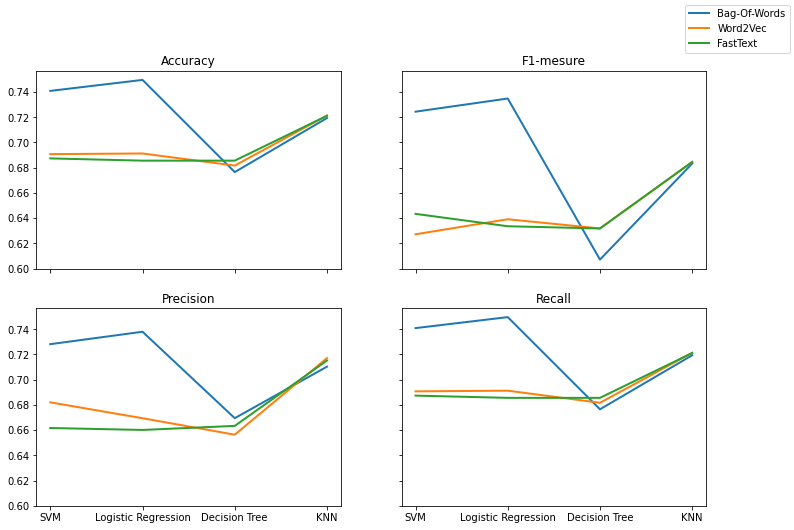

In [136]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharey = True, sharex = True)

axes[0, 0].plot(metrics_bow['model'], metrics_bow['accuracy'], linestyle = 'solid', linewidth = 2, label = 'Bag-Of-Words')
axes[0, 0].plot(metrics_w2v['model'], metrics_w2v['accuracy'], linestyle = 'solid', linewidth = 2, label = 'Word2Vec')
axes[0, 0].plot(metrics_ftxt['model'], metrics_ftxt['accuracy'], linestyle = 'solid', linewidth = 2, label = 'FastText')
axes[0, 0].set_title('Accuracy')

axes[0, 1].plot(metrics_bow['model'], metrics_bow['f1'], linestyle = 'solid', linewidth = 2)
axes[0, 1].plot(metrics_w2v['model'], metrics_w2v['f1'], linestyle = 'solid', linewidth = 2)
axes[0, 1].plot(metrics_ftxt['model'], metrics_ftxt['f1'], linestyle = 'solid', linewidth = 2)
axes[0, 1].set_title('F1-mesure')

axes[1, 0].plot(metrics_bow['model'], metrics_bow['precision'], linestyle = 'solid', linewidth = 2)
axes[1, 0].plot(metrics_w2v['model'], metrics_w2v['precision'], linestyle = 'solid', linewidth = 2)
axes[1, 0].plot(metrics_ftxt['model'], metrics_ftxt['precision'], linestyle = 'solid', linewidth = 2)
axes[1, 0].set_title('Precision')

axes[1, 1].plot(metrics_bow['model'], metrics_bow['recall'], linestyle = 'solid', linewidth = 2)
axes[1, 1].plot(metrics_w2v['model'], metrics_w2v['recall'], linestyle = 'solid', linewidth = 2)
axes[1, 1].plot(metrics_ftxt['model'], metrics_ftxt['recall'], linestyle = 'solid', linewidth = 2)
axes[1, 1].set_title('Recall')

f.legend()
f.show()